In [79]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import hstack

import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

#### some helper stuff for tracking performance over the duration of the project

In [2]:
def write_model_timestamp(model_type, kfolds, scores, note):
    '''
    Parameters:
    model_type = string description of the model(s) used to make these scores
    kfolds     = how many folds in kfold cross validation used
    scores     = list of ROC AUC avg scores of models for each class, floats should be like 0.9784
    note       = string, whatever is of note about the model, made a change or whatever
    
    Returns:
    None, but writes (appends) a line to scores.txt in the root directory so that progress can be tracked
    The format is:
            time(s)~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
            
    scores.txt is a tilde '~' seperated CSV like:
        time~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
        1520303252~0.9794005980274005~note something
    '''

    out_text = "{:10.0f}~{:}~{:2d}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:}\n".format(time.time(), 
                                             model_type, 
                                             kfolds, 
                                             np.mean(scores),
                                             scores[0],
                                             scores[1],
                                             scores[2],
                                             scores[3],
                                             scores[4],
                                             scores[5],                                                
                                             note)
    
    with open("../scores.txt", 'a') as out_file:
        out_file.write(out_text)
        
        print("wrote:")
        print(out_text)
        print("to file")

#### Load data and light processing

In [3]:
train = pd.read_csv('../data/train.csv').fillna(' ')
test = pd.read_csv('../data/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

#### Vectorize words from both corpuses (corpi?)

In [4]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)    # 10k was initial

word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [5]:
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

print("train shape:", train_word_features.shape)
print("test shape:", test_word_features.shape)

train shape: (159571, 5000)
test shape: (153164, 5000)


In [27]:
proto = train.iloc[:100, :]

rage = train.loc[np.sum(train.iloc[:,2:], axis=1) >= 1]

rage.info()

rage_vec_words = word_vectorizer.transform(rage.loc[:, "comment_text"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16225 entries, 6 to 159554
Data columns (total 8 columns):
id               16225 non-null object
comment_text     16225 non-null object
toxic            16225 non-null int64
severe_toxic     16225 non-null int64
obscene          16225 non-null int64
threat           16225 non-null int64
insult           16225 non-null int64
identity_hate    16225 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.1+ MB


In [41]:

pca_snip = rage_vec_words.todense()
pca = PCA(n_components=50)
pca_result = pca.fit_transform(pca_snip)

In [42]:
pca_result.shape

(16225, 50)

In [69]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16225 samples in 0.040s...
[t-SNE] Computed neighbors for 16225 samples in 33.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16225
[t-SNE] Computed conditional probabilities for sample 2000 / 16225
[t-SNE] Computed conditional probabilities for sample 3000 / 16225
[t-SNE] Computed conditional probabilities for sample 4000 / 16225
[t-SNE] Computed conditional probabilities for sample 5000 / 16225
[t-SNE] Computed conditional probabilities for sample 6000 / 16225
[t-SNE] Computed conditional probabilities for sample 7000 / 16225
[t-SNE] Computed conditional probabilities for sample 8000 / 16225
[t-SNE] Computed conditional probabilities for sample 9000 / 16225
[t-SNE] Computed conditional probabilities for sample 10000 / 16225
[t-SNE] Computed conditional probabilities for sample 11000 / 16225
[t-SNE] Computed conditional probabilities for sample 12000 / 16225
[t-SNE] Computed conditional probabilities for s

In [77]:
x_dim = tsne_results[:, 0]
y_dim = tsne_results[:, 1]
z_dim = tsne_results[:, 2]

In [38]:
rage.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


len 16224
(16225,)
len 16224
(16225,)
len 16224
(16225,)
len 16224
(16225,)
len 16224
(16225,)
len 16224
(16225,)


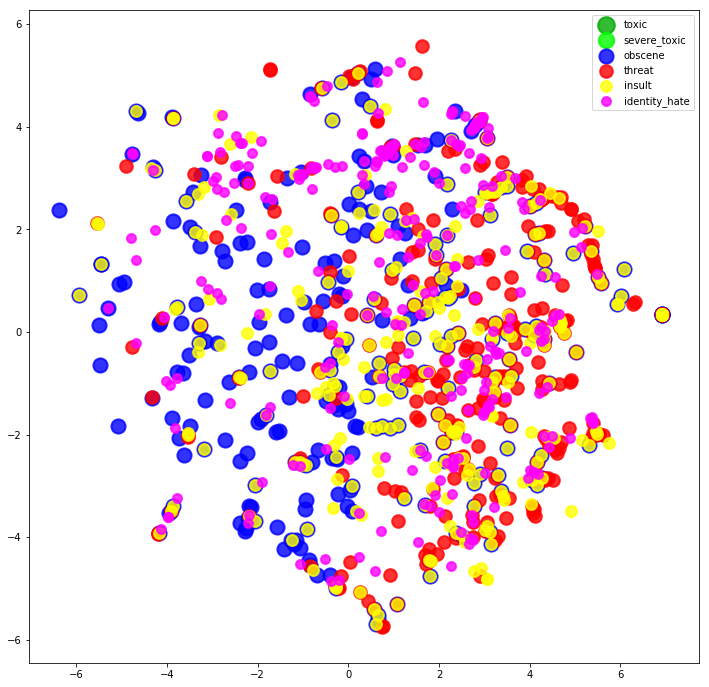

In [78]:
fig, ax = plt.subplots(figsize=(12,12))

colors = ["#00AA00", "#00FF00", "#0000FF", "#FF0000", "#FFFF00", "#FF00FF"]
class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for idx in range(6):
    indices = np.arange(0, len(rage))

    # indices.reshape()

    print("len", len(rage)-1)

    print(indices.shape)

#     # for col in colors:
#     temp = indices[labels[:,idx]==1]
#     temp = temp[:3000]

    # print(temp[:10])
    ax.scatter(x_dim[rage.iloc[:,idx]==1][:300],
               y_dim[rage.iloc[:,idx]==1][:300],
               s=(240-((idx-1)*40)),
               lw=2,
               edgecolor=colors[idx],
               color=colors[idx],
               label=class_names[idx],
               alpha=0.8)
    
ax.legend()

In [220]:
for aaa, ang in enumerate(range(0, 360, 1)):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    sizes = [0, 900, 400, 150, 0, 90]
    alphas = [0.3, 0.3, 0.3, 0.5, 0, 0.5]
    markers = ["o", "o", "^", "X", "o", "^"]
    counts = [300, 300, 500, 1000, 0, 1500]
    colors = ["#22c922", "#22c922", "#4444ff", "red", "#FFFF00", "#804080"]
    class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

    for idx in range(2, 8):
        idy = idx - 2
        if idy != 0 and idy != 4:
        #     # for col in colors:
        #     temp = indices[labels[:,idx]==1]
        #     temp = temp[:3000]

            ax.scatter(
                    x_dim[rage.iloc[:,idx]==1][:counts[idy]],
                    y_dim[rage.iloc[:,idx]==1][:counts[idy]],
                    z_dim[rage.iloc[:,idx]==1][:counts[idy]],
                    zdir='z',
                    color=colors[idy],
                    label=class_names[idy],
                    s=sizes[idy],
                    marker=markers[idy],
                    alpha=alphas[idy])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_xlim(-3.25, 3.25)
            ax.set_ylim(-3.25, 3.25)
            ax.set_zlim(-3.25, 3.25)
            ax.w_xaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))
            ax.w_yaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))
            ax.w_zaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))
#             ax.set_axis_off()
            ax.autoscale_view(tight=True)

    ax.legend(fontsize=16, loc=1)
    ax.view_init(15 + 15 * np.sin(ang * np.pi / 180), ang)
    
    
    filename = "../imgs/{:03d}.png".format(aaa)
    plt.savefig(filename, dpi=100)
    plt.gca()
    plt.clf()
    plt.close()

In [119]:
x_dim[rage.iloc[:,2]==1]
# x_dim[rage.iloc[:,2]==1][:300]

array([-3.8704715 , -0.02555365, -2.241838  , ...,  0.4592499 ,
        0.36266276,  1.9928123 ], dtype=float32)